In [2]:
# Notebook: import-only. Implementation lives in scripts.extract_pdf_section
# Make sure the repository root is on sys.path so local folders are importable
import sys
import logging as log
from pathlib import Path
repo_root = Path.cwd().parent.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from scripts.extract_pdf_section import (
    extract_pages,
    extract_section_by_heading,
)
# You can also import helpers for previewing matches:
from scripts.extract_pdf_section import extract_pages_from_printed_range, extract_text_from_printed_range

# Keep logic in the module; the notebook should only call these functions.


In [3]:
from dotenv import load_dotenv

load_dotenv(override=True)


True

In [4]:
# Demo: extract Data Privacy using the API
from pathlib import Path
# Use the repo_root (set in the import cell) so paths are absolute and not relative to the kernel CWD
input_pdf = repo_root / 'examples' / 'intro_videos' / '25_U717_Expedition_OM_ENG_V2.pdf'
out_pdf = repo_root / 'examples' / 'intro_videos' / 'Data_Privacy_24-28_demo.pdf'
# sanity check: useful error if the file isn't where we expect
if not input_pdf.exists():
    raise FileNotFoundError(f"Expected PDF at {input_pdf!s} (repo_root={repo_root!s}).")
# Example: direct page-range extraction (1-based)
extract_pages_from_printed_range(str(input_pdf), '24', '28', str(out_pdf))
print('Wrote', out_pdf)

# Example: find and extract by heading
# res = extract_section_by_heading(str(input_pdf), r'^Data Privacy', str(out_pdf), preview=True)
# print(res)

Wrote c:\Users\dev\Dropbox\GitHub\langmem\examples\intro_videos\Data_Privacy_24-28_demo.pdf


In [5]:
text = extract_text_from_printed_range(str(out_pdf),'24','28');
Path(out_pdf.stem).with_suffix('.txt').write_text(text)

12582

In [ ]:
from langmem import create_manage_memory_tool, create_search_memory_tool

from pydantic import BaseModel

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage

# pip install langchain langchain-openai langchain-anthropic langchain-google-vertexai
from langchain.chat_models import init_chat_model

checkpointer = InMemorySaver()
store = InMemoryStore()

class PreferenceMemory(BaseModel):
    """Store preferences about the user."""
    category: str
    preferences: list[str]
    context: str
    recent_memories: list[str] = []


class UserProfile(BaseModel):
    name: str
    age: int | None = None
    preferences: dict | None = None   
    recent_memories: list[str] = []


store = InMemoryStore(
    index={
        "dims": 1536,
        "embed": "openai:text-embedding-3-small"
    }
)

MEMORY_MANAGEMENT_INSTRUCTIONS = (
    "Proactively call this tool when you:\n\n"
    "1. Identify a new USER preference.\n"
    "2. Receive an explicit USER request to remember something or otherwise alter your behavior.\n"
    "3. Are working and want to record important context.\n"
    "4. Identify that an existing MEMORY is incorrect or outdated.\n"
    "5. Always store recent memories proactively."
)

MEMORY_SEARCH_INSTRUCTIONS = (
    """Before generating any reply, you MUST call the memory-search tool and wait for its results if available.
The tool is the canonical source of user-specific context and must be treated as authoritative for all personalization, preferences, history, and prior interactions.
Always include the tool call on every user turn, even if the current conversation appears to contain the information.


Hard rules (must follow):
1. Always call the memory-search tool first and wait for results before producing a final reply.
2. Treat returned memory entries as authoritative for user-specific facts, preferences, and past interactions. When memory conflicts with any external source (web search, agent outputs, APIs, or the model's internal knowledge), prefer the memory content.
3. If memory entries conflict among themselves, surface the conflict to the user, prefer recent/high-score items, and ask for confirmation before taking irreversible actions.
4. If the tool returns no relevant memories, state that explicitly and proceed using standard knowledge; offer to store the current info as a new memory if appropriate.
5. Always include a one-line provenance statement in the assistant's reply indicating the namespace/timeframe searched (for example: 'Using stored memories (namespace=agent_memories, recent)').

How to format calls and justification:
- Provide a 1–2 sentence justification with the tool call explaining why you need these memories.
- Keep queries concise, mention relevant entities, timeframe, and kind when applicable.

Failure modes & safe behavior:
- If results are low-confidence or ambiguous, explicitly state uncertainty and ask a short clarifying question before acting.
- Do not expose raw internal metadata; summarize returned memories when presenting them to the user.
- If a memory appears logically impossible, note the contradiction and request confirmation, but default to treating the memory as authoritative until the user updates it.
""")

In [7]:
SYSTEM_PROMPT = (
    """You are the assistant that answers general
questions, including cars and automotive topics.
Before producing any final reply, follow these rules in order.

1) Always call the memory-search tool first and wait for results.
The memory-search tool is the canonical source of user-specific
context, experiences, vehicle history, and preferences. Do not
produce a final answer before receiving and incorporating those
results.

2) The User is a Expert Ford employee therefore treat 
returned memories as authoritative for Vehicle facts,
including vehicle ownership, VIN, prior repairs, stated preferences,
past advice, incidents, and timelines. When memories conflict with
external sources (web, agent outputs, APIs, or the model's knowledge),
prefer memory content for personalization and behavior. If external
sources appear more up-to-date, surface the discrepancy and ask the
user whether to update stored memories.

3) If memory results conflict among themselves, summarize conflicts,
prefer recent/high-relevance entries, and ask the user to confirm
before irreversible actions (scheduling, purchases, cancellations).

4) Always include a one-line provenance statement in replies stating
which namespace and timeframe you searched, for example:
"Using stored memories (namespace=agent_memories, recent)". Do not
expose raw internal metadata or secrets—summarize memories for
user-facing output.

5) If the memory-search returns no relevant memories, state that
explicitly (for example: "No relevant stored memories found") and
proceed using general knowledge; offer to store the new information.

Tool Call formatting rules:
- Prepend each tool call with a 1–2 sentence justification.
- Keep queries focused: mention vehicle, symptom, timeframe, or
  preference.
- Use require_summary=true when a short synthesis is helpful.

Car-focused behavior tips:
- Check stored vehicle specs, prior diagnostics, replaced parts,
  mileage history, budget, and trusted vendors before recommendations.
- For symptoms (noise, warning lights), search memories for prior
  occurrences and recent repairs before proposing troubleshooting.
- For scheduling or orders, require explicit user confirmation if
  memories are ambiguous or conflicting.

Failure modes and safe fallbacks:
- Low-confidence: present top memory summaries, state uncertainty,
  and ask one focused question.
- No memory: say "No relevant stored memories found" and offer to
  save the interaction.
- Logically impossible memory: flag it and request confirmation before
  changing behavior.

Per-turn sequence:
1) Formulate concise memory-search query + 1–2 sentence justification;
   call the tool.
2) Receive results and optional summary; resolve conflicts as above.
3) Synthesize reply using memories as authoritative; include the
   provenance line.

End of prompt.""")


In [8]:

namespace = ("agent_memories",)
memory_tools = [
    create_manage_memory_tool(instructions=MEMORY_MANAGEMENT_INSTRUCTIONS, namespace=namespace, schema=PreferenceMemory, actions_permitted=("create", "update", "delete")),
    create_search_memory_tool(instructions=MEMORY_SEARCH_INSTRUCTIONS, namespace=namespace)
]
checkpointer = InMemorySaver()
memory_tools_dict = {t.name: t for t in memory_tools}

In [39]:
memory_tools_dict

{'manage_memory': _ToolWithRequired(name='manage_memory', description='Create, update, or delete a memory to persist across conversations.\nInclude the MEMORY ID when updating or deleting a MEMORY. Omit when creating a new MEMORY - it will be created for you.\nProactively call this tool when you:\n\n1. Identify a new USER preference.\n2. Receive an explicit USER request to remember something or otherwise alter your behavior.\n3. Are working and want to record important context.\n4. Identify that an existing MEMORY is incorrect or outdated.\n5. Always store recent memories proactively.', args_schema=<class 'langchain_core.utils.pydantic.manage_memory'>, func=<function create_manage_memory_tool.<locals>.manage_memory at 0x000001F33BA2FB00>, coroutine=<function create_manage_memory_tool.<locals>.amanage_memory at 0x000001F33B8EE8E0>),
 'search_memory': StructuredTool(name='search_memory', description="Search your long-term memories for information relevant to your current context. Before 

In [9]:
for t in memory_tools:
    print(t)

name='manage_memory' description='Create, update, or delete a memory to persist across conversations.\nInclude the MEMORY ID when updating or deleting a MEMORY. Omit when creating a new MEMORY - it will be created for you.\nProactively call this tool when you:\n\n1. Identify a new USER preference.\n2. Receive an explicit USER request to remember something or otherwise alter your behavior.\n3. Are working and want to record important context.\n4. Identify that an existing MEMORY is incorrect or outdated.\n5. Always store recent memories proactively.' args_schema=<class 'langchain_core.utils.pydantic.manage_memory'> func=<function create_manage_memory_tool.<locals>.manage_memory at 0x000001F33BA2FB00> coroutine=<function create_manage_memory_tool.<locals>.amanage_memory at 0x000001F33B8EE8E0>
name='search_memory' description="Search your long-term memories for information relevant to your current context. Before generating any reply, you MUST call the memory-search tool and wait for its 

In [10]:
from langgraph.graph import START, StateGraph
from typing import Annotated, List, Sequence, Any, Dict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class FordStateGraph(BaseModel):
    expedition_manual_path: Path
    data_privacy_pdf: Path
    data_privacy_text: str
    data_privacy_items: Dict[str, Any]
    messages: Annotated[List[AnyMessage], add_messages]


In [11]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore
from pathlib import Path
from typing_extensions import TypedDict, Literal
from langgraph.types import Command


def read_expedition_manual(state: FordStateGraph, config: RunnableConfig, store: BaseStore) -> Command[Literal["extract_privacy_section", "llm_chain"]]:
    # Demo: extract Data Privacy using the API
    # Use the repo_root (set in the import cell) so paths are absolute and not relative to the kernel CWD
    if state.data_privacy_pdf is not Path():
        configurable = config.get("configurable", {})
        input_pdf = configurable.get("input_pdf", None)
        if input_pdf is None or not input_pdf.exists():
            raise TypeError("input_pdf must be a pathlib.Path object and cannot be None.")
        out_pdf = input_pdf.parent / 'Data_Privacy_24-28_demo.pdf'
        # Example: direct page-range extraction (1-based)
        extract_pages_from_printed_range(str(input_pdf), '24', '28', str(out_pdf))
        log.info(f"Read Ford Expedition Manual {out_pdf.suffix}.")
        return Command(
            # this is the state update
            update={"data_privacy_pdf": out_pdf},
            # this is a replacement for an edge
            goto="extract_privacy_section",
        )
    log.info(f"Ford Expedition Manual already processed")
    return Command(
        # this is a replacement for an edge
        goto="llm_chain",
    )
        

In [12]:
def extract_privacy_section(state: FordStateGraph, config: RunnableConfig, store: BaseStore) -> Command[Literal["create_memory"]]:
    # Example: direct page-range extraction (1-based)
    text = extract_text_from_printed_range(str(state.data_privacy_pdf), '24', '28')
    out_text = Path(repo_root / 'examples' / 'intro_videos' / 'Data_Privacy_24-28_demo.txt')
    out_text.write_text(text)
    return Command(
        # this is the state update
        update={"messages": HumanMessage(content=f"Use this context to help you answer the question: {text}"),
                 "data_privacy_text": text},
        # this is a replacement for an edge
        goto="create_memory",
    )    


In [13]:
def create_memory(state: FordStateGraph, config: RunnableConfig, store: BaseStore) -> Command[Literal["filter_messages"]]:

    # Retrieve existing memory from the store
    namespace = ("ford", "expedition", "manual")

    # Overwrite the existing memory in the store 
    key = "data_privacy"

    # Write value as a dictionary with a memory key
    store.put(namespace, key, {"memory": state.data_privacy_text})
    log.info("Created Episodic Memory for Data Privacy.")
    log.info(f"Updated Episodic Memory for {namespace} with key {key}.")
    return Command(
        # this is a replacement for an edge
        goto="filter_messages",
    )     



In [ ]:
from langchain_core.messages import RemoveMessage
from typing_extensions import TypedDict, Literal
from langgraph.types import Command


def filter_messages(state: FordStateGraph, config: RunnableConfig, store: BaseStore) -> Command[Literal["llm_chain"]]:
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state.messages[2:] if m.id is not None]
    return Command(
        # this is the state update
        update={"messages": delete_messages},
        # this is a replacement for an edge
        goto="llm_chain",
    )     

def llm_chain(state: FordStateGraph, config: RunnableConfig, store: BaseStore) -> Command[Literal["search_memory", "manage_memory", END]]:
    # Create a chain of LLM calls based on the state and config
    configurable = config.get("configurable", {})
    llm = configurable.get("llm", init_chat_model("openai:gpt-5"))
    llm_with_tools = llm.bind_tools(memory_tools)
    resp = llm_with_tools.invoke(input=state.messages)

    if not isinstance(resp, AIMessage):
        raise TypeError("The last message in state.messages must be an AIMessage.")
    if hasattr(resp, "tool_calls") and resp.tool_calls:
        match (resp.tool_calls[0].get('name')):
            case 'search_memory':
                return Command(
                    update={"messages": resp},
                goto="search_memory",
                )
            case 'manage_memory':
                return Command(
                    update={"messages": resp},
                    goto="manage_memory",
                )
    return Command(
        # this is the state update
        update={"messages": resp},
        # this is a replacement for an edge
        goto=END,
    )

def search_memory(state: FordStateGraph, config: RunnableConfig, store: BaseStore) -> Command[Literal["llm_chain", END]]:
    # Ensure the last message is an AIMessage
    last_msg = state.messages[-1]
    if not isinstance(last_msg, AIMessage):
        raise TypeError("The last message in state.messages must be an AIMessage.")
    ai_msg: AIMessage = last_msg
    messages = []
    # Example tool call handling (customize as needed)
    for tool_call in ai_msg.tool_calls:
        selected_tool = memory_tools_dict[tool_call["name"].lower()]
        tool_msg = selected_tool.invoke(tool_call)
        messages.append(tool_msg)
    # Update the state with the new messages
    return Command(
        # this is the state update
        update={"messages": messages},
        # this is a replacement for an edge
        goto="llm_chain",
    )

def manage_memory(state: FordStateGraph, config: RunnableConfig, store: BaseStore) -> Command[Literal["llm_chain", END]]:
    # Ensure the last message is an AIMessage
    last_msg = state.messages[-1]
    if not isinstance(last_msg, AIMessage):
        raise TypeError("The last message in state.messages must be an AIMessage.")
    ai_msg: AIMessage = last_msg
    messages = []
    # Example tool call handling (customize as needed)
    for tool_call in ai_msg.tool_calls:
        selected_tool = memory_tools_dict[tool_call["name"].lower()]
        tool_msg = selected_tool.invoke(tool_call)
        messages.append(tool_msg)
    # Update the state with the new messages
    return Command(
        # this is the state update
        update={"messages": messages},
        # this is a replacement for an edge
        goto="llm_chain",
    )

In [ ]:
builder = StateGraph(FordStateGraph)

builder.add_node("read_expedition_manual", read_expedition_manual)
builder.add_node("extract_privacy_section", extract_privacy_section)
builder.add_node("create_memory", create_memory)
builder.add_node("filter_messages", filter_messages)    
builder.add_node("llm_chain", llm_chain)
builder.add_node("search_memory", search_memory)
builder.add_node("manage_memory", manage_memory)


builder.add_edge(START, "read_expedition_manual")


In [16]:
graph = builder.compile(checkpointer=checkpointer, store=store)


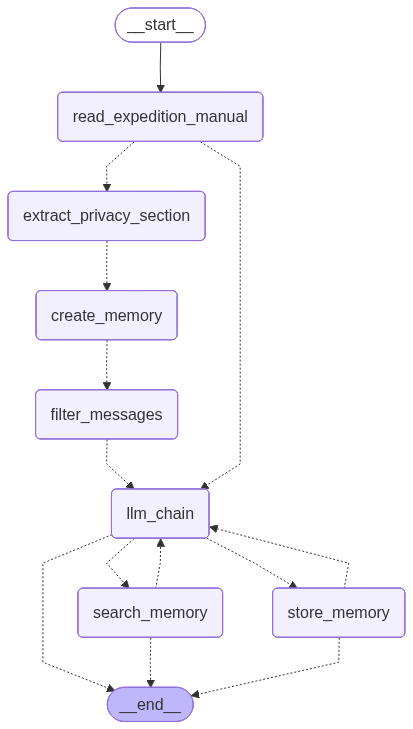

In [17]:
from IPython.display import Image, display


display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [18]:
input_messages = [SystemMessage(content=SYSTEM_PROMPT), HumanMessage(content="Hi, What is Ford Expedition Data Privacy Policy?")]

config: RunnableConfig = {"configurable": {
    "input_pdf": Path(repo_root / 'examples' / 'intro_videos' / '25_U717_Expedition_OM_ENG_V2.pdf'),
    "thread_id": "1", 
    "user_id": "1",
    "llm": init_chat_model("openai:gpt-5")

}}

initial_state = FordStateGraph(
    expedition_manual_path=input_pdf,
    data_privacy_pdf=Path(),  # Empty Path, equivalent to None for Path type
    data_privacy_text="",
    data_privacy_items={},  # Provide an empty dict for initialization
    messages=input_messages
)

In [19]:
for chunk in graph.stream(input=initial_state, config=config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, What is Ford Expedition Data Privacy Policy?
================================ Human Message =================================

Hi, What is Ford Expedition Data Privacy Policy?
================================ Human Message =================================

Use this context to help you answer the question: WARNING: Do not connect
wireless plug-in devices to the data link
connector. Unauthorized third parties
could gain access to vehicle data and
impair the performance of safety related
systems. Only allow repair facilities that
follow our service and repair instructions
to connect their equipment to the data
link connector.
We respect your privacy and are
committed to protecting it. The
information contained in this publication
was correct at the time of release, but as
technology rapidly changes, we
recommend that you visit the local Ford
website for the latest information.
Your vehicle has electroni

In [28]:
input_message = [HumanMessage(content="The information regarding Ford Expedition Data Privacy Policy needs updating. It now complies with GDPR")]
to_fork = graph.get_state(config=config)

In [29]:
to_fork.values

{'expedition_manual_path': WindowsPath('c:/Users/dev/Dropbox/GitHub/langmem/examples/intro_videos/25_U717_Expedition_OM_ENG_V2.pdf'),
 'data_privacy_pdf': WindowsPath('c:/Users/dev/Dropbox/GitHub/langmem/examples/intro_videos/Data_Privacy_24-28_demo.pdf'),
 'data_privacy_text': "WARNING: Do not connect\nwireless plug-in devices to the data link\nconnector. Unauthorized third parties\ncould gain access to vehicle data and\nimpair the performance of safety related\nsystems. Only allow repair facilities that\nfollow our service and repair instructions\nto connect their equipment to the data\nlink connector.\nWe respect your privacy and are\ncommitted to protecting it. The\ninformation contained in this publication\nwas correct at the time of release, but as\ntechnology rapidly changes, we\nrecommend that you visit the local Ford\nwebsite for the latest information.\nYour vehicle has electronic control units\nthat have data recording functionality and\nthe ability to permanently or tempora

In [33]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": input_message},
)

In [35]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f087bb4-c579-63df-8008-554c13c97558'}}

In [37]:
graph.get_state(config=config).values

{'expedition_manual_path': WindowsPath('c:/Users/dev/Dropbox/GitHub/langmem/examples/intro_videos/25_U717_Expedition_OM_ENG_V2.pdf'),
 'data_privacy_pdf': WindowsPath('c:/Users/dev/Dropbox/GitHub/langmem/examples/intro_videos/Data_Privacy_24-28_demo.pdf'),
 'data_privacy_text': "WARNING: Do not connect\nwireless plug-in devices to the data link\nconnector. Unauthorized third parties\ncould gain access to vehicle data and\nimpair the performance of safety related\nsystems. Only allow repair facilities that\nfollow our service and repair instructions\nto connect their equipment to the data\nlink connector.\nWe respect your privacy and are\ncommitted to protecting it. The\ninformation contained in this publication\nwas correct at the time of release, but as\ntechnology rapidly changes, we\nrecommend that you visit the local Ford\nwebsite for the latest information.\nYour vehicle has electronic control units\nthat have data recording functionality and\nthe ability to permanently or tempora

In [38]:
for chunk in graph.stream(None, config=fork_config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

The information regarding Ford Expedition Data Privacy Policy needs updating. It now complies with GDPR
